# Heart Failure Clinical Records Dataset - Lab 5

## MinMax Normalization

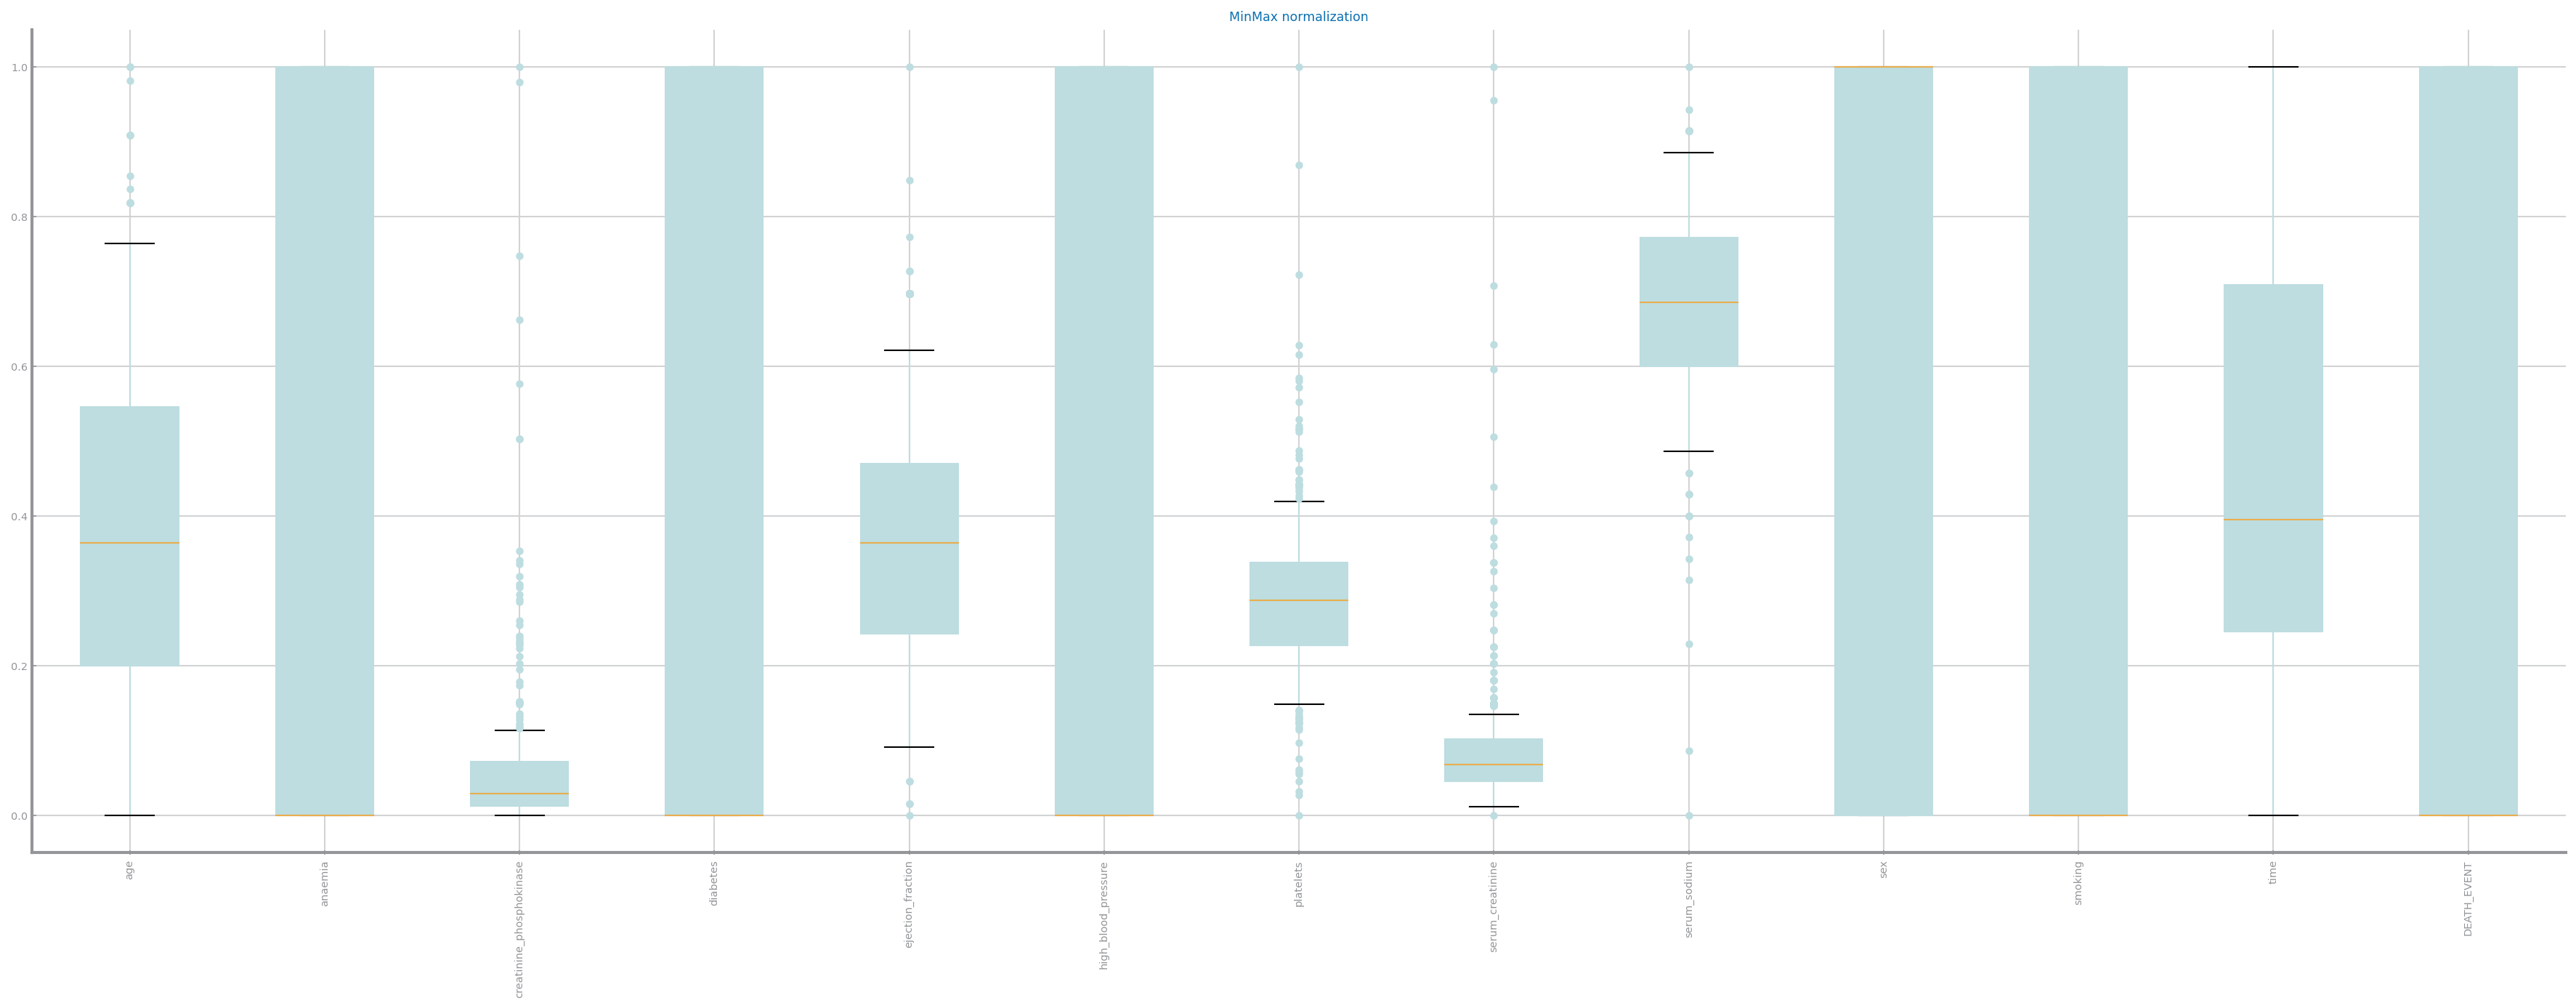

In [86]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import sklearn.metrics as metrics
from numpy import percentile
from subprocess import call

data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
original_data = copy.deepcopy(data)

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_nr = pd.DataFrame(transf.transform(data), columns= data.columns)
norm_data_minmax = df_nr
norm_data_minmax.describe(include='all')

fig, axs = plt.subplots(1, 1, figsize=(30,10),squeeze=False )
axs[0, 0].set_title('MinMax normalization')
# axs[0, 2].xticks(rotation=90)
norm_data_minmax.boxplot(ax=axs[0, 0])
# fig.tight_layout()
plt.setp(axs[0, 0].xaxis.get_majorticklabels(), rotation=90)

plt.show()

## Balancing - Dataset Size

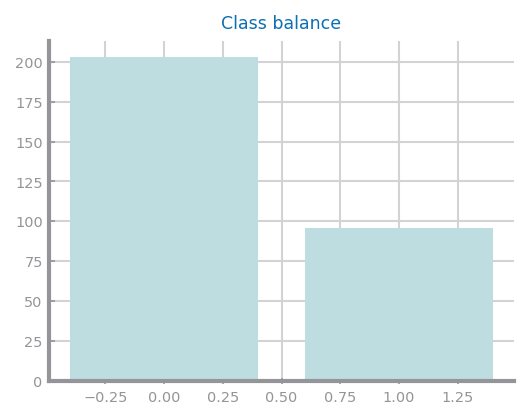

Minority class: 96
Majority class: 203
Proportion: 0.47 : 1


In [87]:
target = 'DEATH_EVENT'
target_count = original_data[target].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 2), ': 1')

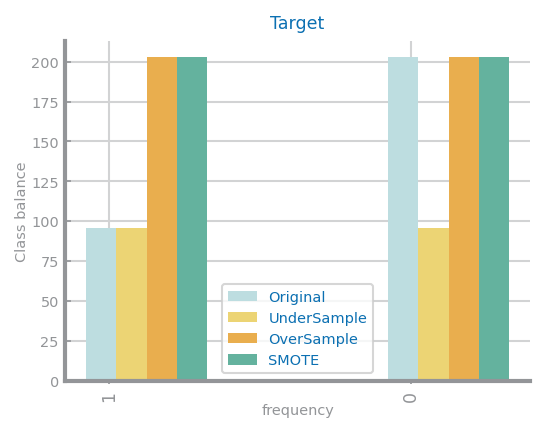

In [88]:
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

df_class_min = original_data[original_data[target] == min_class]
df_class_max = original_data[original_data[target] != min_class]

df_under = df_class_max.sample(len(df_class_min))
values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]
df_over = df_class_min.sample(len(df_class_max), replace=True)
values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original_data.pop(target).values
X = original_data.values
smote_X, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance')
plt.show()

## Unbalanced Classification

{ 299 , 299 }
Confusion Matrix Test
TruePositives:  22
FalsePositives:  5
TrueNegatives:  56
FalseNegatives:  7


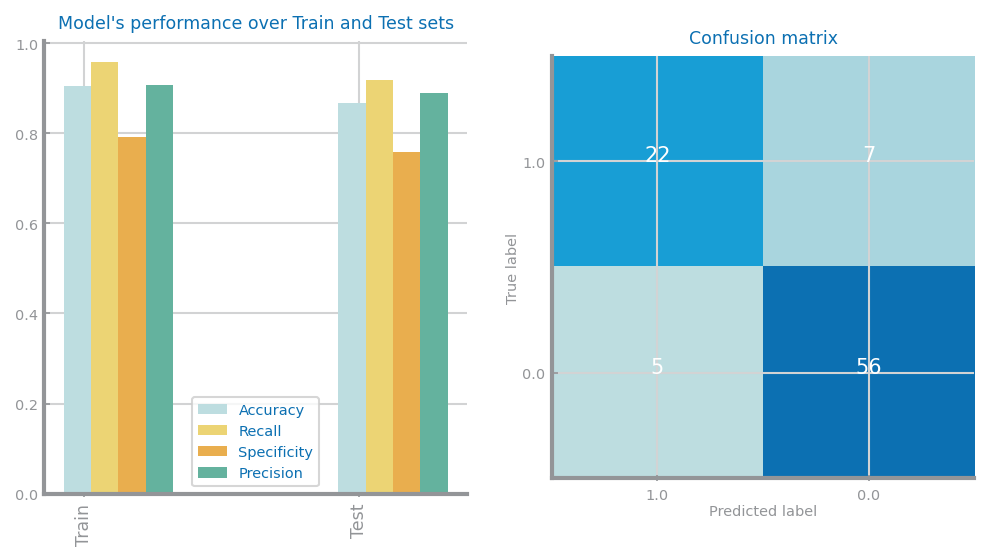

In [89]:
y: np.ndarray = norm_data_minmax.pop(target).values
X: np.ndarray = norm_data_minmax.values

labels = pd.unique(y)
print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None
n = 5
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues

prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## Over Sampled Classification

{ 406 , 406 }
Confusion Matrix Test
TruePositives:  53
FalsePositives:  10
TrueNegatives:  51
FalseNegatives:  8


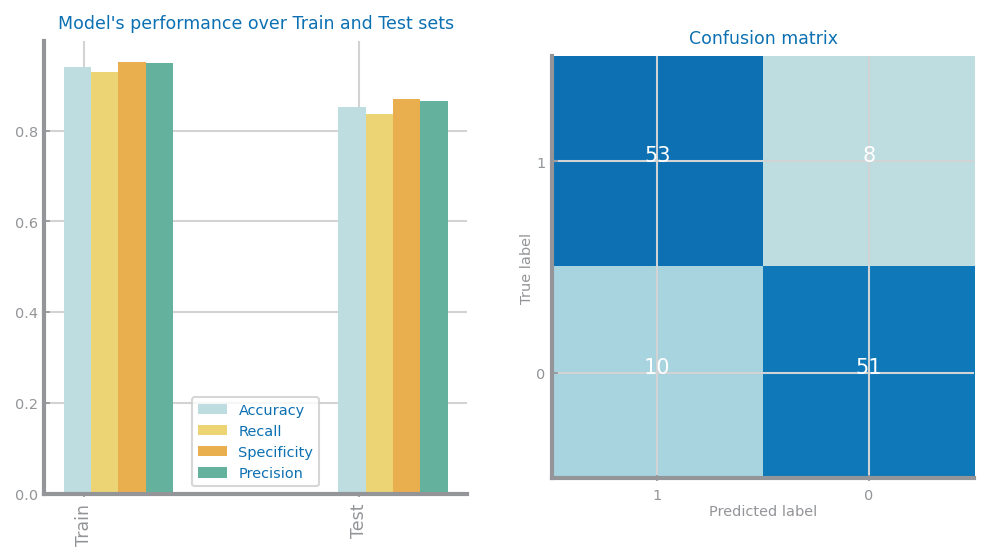

In [76]:
over_sampled = pd.concat([df_over,df_class_max])
y: np.ndarray = over_sampled.pop(target).values
X: np.ndarray = over_sampled.values
labels: np.ndarray = pd.unique(y)

print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None
n = 5
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues

prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## Under Sampled Classification

{ 192 , 192 }
Confusion Matrix Test
TruePositives:  22
FalsePositives:  4
TrueNegatives:  25
FalseNegatives:  7


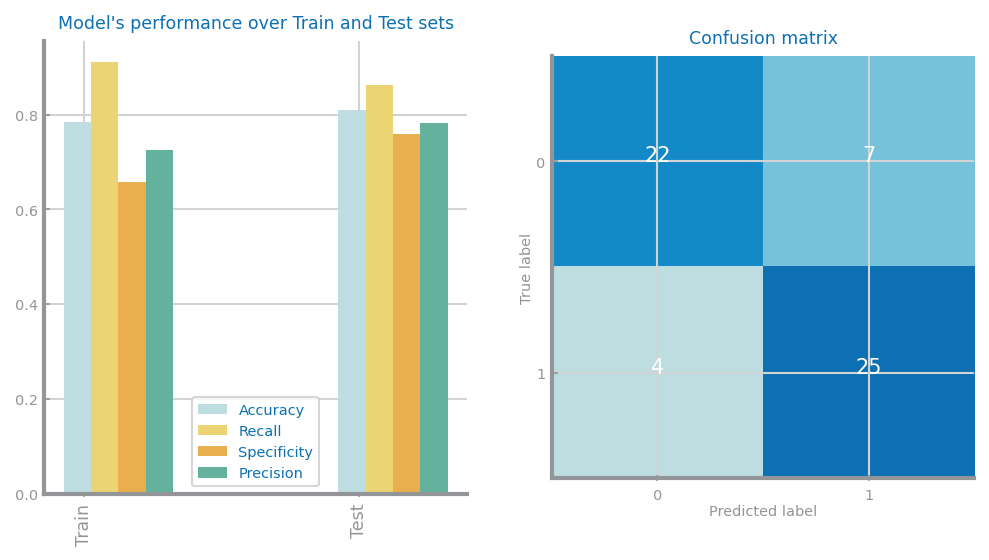

In [72]:
under_sampled = pd.concat([df_under,df_class_min])
y: np.ndarray = under_sampled.pop(target).values
X: np.ndarray = under_sampled.values
labels: np.ndarray = pd.unique(y)

print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None
n = 5
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues

prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## SMOTE Classification

{ 406 , 406 }
Confusion Matrix Test
TruePositives:  51
FalsePositives:  8
TrueNegatives:  53
FalseNegatives:  10


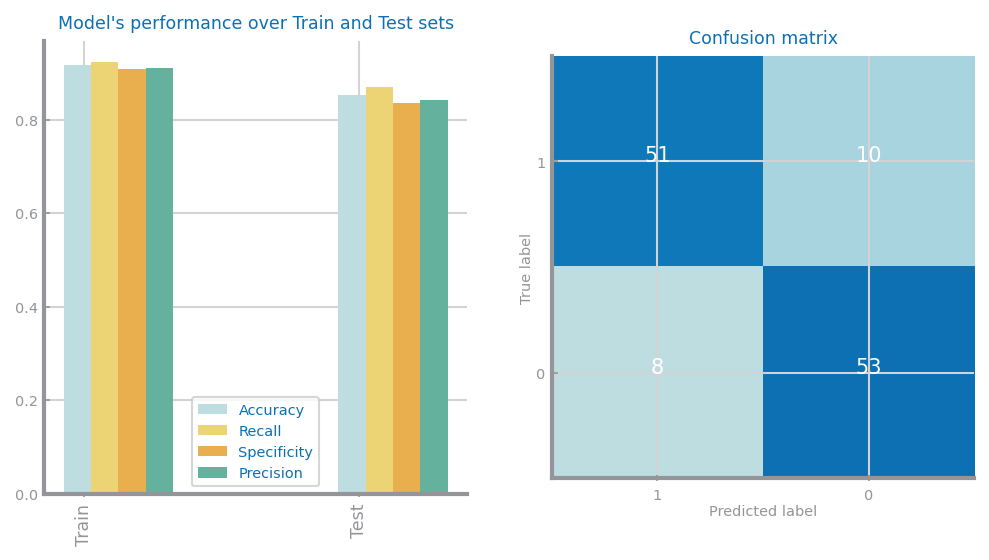

In [90]:
y = smote_y
X = smote_X
labels = pd.unique(y)
    
print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None
n = 5
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues

prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)